# Лабораторная работа №6.
## Сети Кохонена.
### Выполнила: Михеева Кристина Олеговна
#### Группа М8О-407Б-20
##### Вариант: 15

## Цель работы

Целью работы является исследование свойств слоя Кохонена, карты Кохонена, а также сетей векторного квантования, обучаемых с учителем, алгоритмов обучения, а также применение сетей в задачах кластеризации и классификации.


## Ход работы

## Задание 1
Использовать слой Кохонена для выполнения кластеризации множества точек. Проверить качество разбиения.



In [149]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from tqdm import tqdm, trange

from minisom import MiniSom

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D



 Напишем слой Кохонена

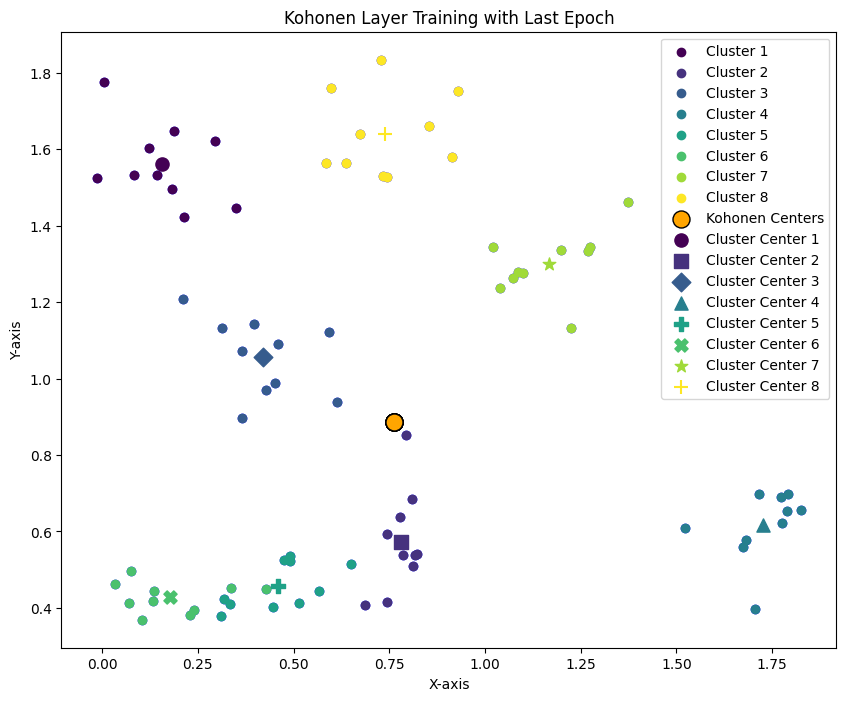

In [76]:
class KohonenLayer:
    def __init__(self, input_size, map_width, map_height):
        self.weights = np.random.rand(map_width, map_height, input_size)
        self.map_width = map_width
        self.map_height = map_height
        self.training_history = []

    def train(self, data, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            for x in data:
                best_node = self.find_best_matching_unit(x)
                self.update_weights(x, best_node, learning_rate, epoch, num_epochs)
            self.training_history.append(np.copy(self.weights))

    def find_best_matching_unit(self, x):
        distances = np.linalg.norm(self.weights - x, axis=-1)
        best_node = np.unravel_index(np.argmin(distances), distances.shape[:2])
        return best_node

    def update_weights(self, x, best_node, learning_rate, epoch, num_epochs):
        decay = 1 - epoch / num_epochs
        influence = np.exp(-decay)
        for i in range(self.map_width):
            for j in range(self.map_height):
                distance = np.linalg.norm(np.array(best_node) - np.array([i, j]))
                self.weights[i][j] += learning_rate * influence * (x - self.weights[i][j])

# Генерация данных для обучения
MAX_CORD = 1.8
DEVIATION = 0.1
clusters = 8
points_per_cluster = 10
points, classes = make_blobs(
    clusters * points_per_cluster,
    centers=clusters,
    center_box=(0, MAX_CORD),
    cluster_std=DEVIATION,
)

# Создание и обучение слоя Kohonen
map_width = 3
map_height = 3
kohonen = KohonenLayer(input_size=2, map_width=map_width, map_height=map_height)
num_epochs = 50
learning_rate = 0.1
kohonen.train(points, num_epochs, learning_rate)

centers = np.empty((clusters, 2))  # Создаем пустой массив для центров кластеров
for i in range(clusters):
    cluster_data = points[classes == i]  # Фильтруем данные для каждого кластера
    center = np.mean(cluster_data, axis=0)  # Находим среднее значение по каждой оси для каждого кластера
    centers[i] = center  # Сохраняем центр кластера

# Визуализация истории обучения слоя Кохонена
def plot_last_epoch_unique_centers(history):
    h = history[-1]
    data = np.copy(h).reshape(map_width * map_height, 2)

    cluster_colors = plt.cm.viridis(np.linspace(0, 1, clusters))  # Генерация цветов для кластеров
    markers = ['o', 's', 'D', '^', 'P', 'X', '*', '+']  # Маркеры для центров кластеров

    plt.figure(figsize=(10, 8))  # Изменение размера графика
    plt.scatter(points[:, 0], points[:, 1], color='blue')  # Визуализация исходных данных в синем цвете
    for cl, color, marker in zip(range(clusters), cluster_colors, markers):  # Перекраска и изменение маркеров кластеров
        cluster_data = points[classes == cl]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=color, label=f'Cluster {cl + 1}')

    plt.scatter(data[:, 0], data[:, 1], color='orange', label='Kohonen Centers', edgecolors='black', s=150, marker='o')  # Выделение центров кластеров

    # Визуализация уникальных центров кластеров с разными маркерами
    for i in range(clusters):
        plt.scatter(centers[i, 0], centers[i, 1], color=cluster_colors[i], label=f'Cluster Center {i + 1}', s=90, marker=markers[i])

    plt.title('Kohonen Layer Training with Last Epoch')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

plot_last_epoch_unique_centers(kohonen.training_history)

##  Задание 2
Использовать карту Кохонена для выполнения кластеризации множества точек.

Функция отрисовки гексогональной сетки.

In [192]:
def DrawHex(x2, y2, xx, yy, umatrix, weights):
    f = plt.figure(figsize=(15,15))
    ax = f.add_subplot()

    ax.set_aspect('equal')

    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
            hex = RegularPolygon((xx[(i, j)], wy),
                                 numVertices=6,
                                 radius=0.95 / np.sqrt(3),
                                 facecolor=cm.Blues(umatrix[i, j]),
                                 alpha=0.4,
                                 edgecolor='pink')
            ax.add_patch(hex)

    markers = ['o', 'v', 'x', '*', 'D', 'H', 'P', 's']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:grey', 'tab:cyan']
    for cnt, x in enumerate(x2):
        w = som.winner(x)
        wx, wy = som.convert_map_to_euclidean(w)
        wy = wy * 2 / np.sqrt(3) * 3 / 4
        plt.plot(wx, wy,
                 markers[y2[cnt]],
                 markerfacecolor='None',
                 markeredgecolor=colors[y2[cnt]],
                 markersize=12,
                 markeredgewidth=2)

    xrange = np.arange(weights.shape[0])
    yrange = np.arange(weights.shape[1])
    plt.xticks(xrange-0.5, xrange)
    plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues,
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('Расстояние от нейронов по соседству',
                      rotation=270, fontsize=16)
    plt.gcf().add_axes(ax_cb)

    legend_elements = [Line2D([0], [0], marker='o', color='tab:blue', label='0',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='v', color='tab:orange', label='1',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='x', color='tab:green', label='2',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='*', color='tab:red', label='3',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='D', color='tab:purple', label='4',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='H', color='tab:brown', label='5',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='P', color='tab:pink', label='6',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='s', color='tab:cyan', label='7',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left',
              borderaxespad=0., ncol=8, fontsize=14)
    plt.show()

In [193]:
x2, y2 = make_blobs(n_samples=80, cluster_std=0.1, n_features=2,
                    centers=8, center_box=(0, 1.5), random_state=91)


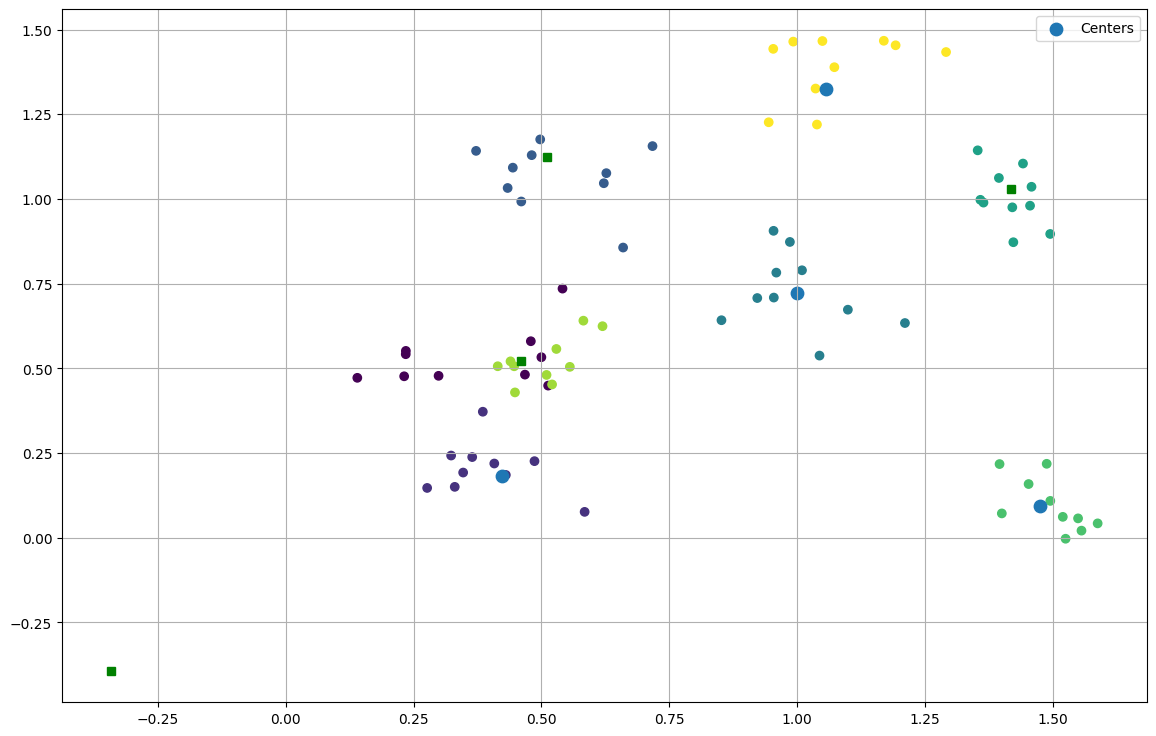

In [194]:
plt.figure(figsize=(14, 9))
plt.scatter(x2[:, 0], x2[:, 1], c=y2, cmap='viridis')
plt.scatter(weights[0][:,0], weights[0][:,1], s=80, label='Сenters')
plt.plot(weights[1][:,0], weights[1][:,1], 'gs')
plt.legend()
plt.grid(True)



Обучим сеть.

In [ ]:
epochs = 150
som = MiniSom(2, 4, x2.shape[1], sigma=0.66, learning_rate=0.8, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)
som.train(x2, epochs, verbose=True)



In [196]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()




Гексогональная сетка для обучающего множества.


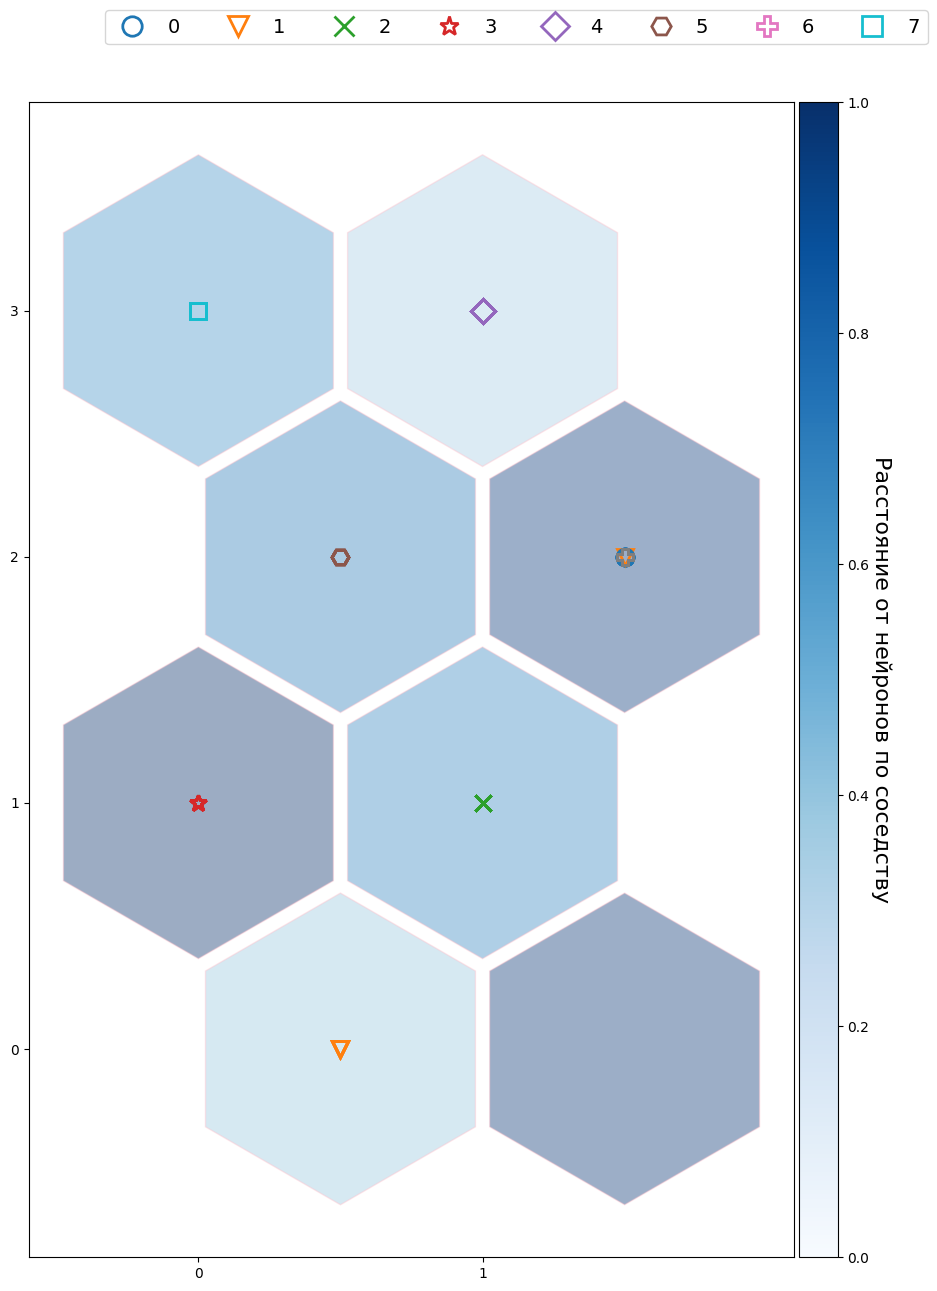

In [197]:
DrawHex(x2, y2, xx, yy, umatrix, weights)

## Задание 3
Использовать карту Кохонена для нахождения одного из решений задачи коммивояжера.

Сгенерируем набор из 20 случайных точек из диапазона [-1.5, 1.5].

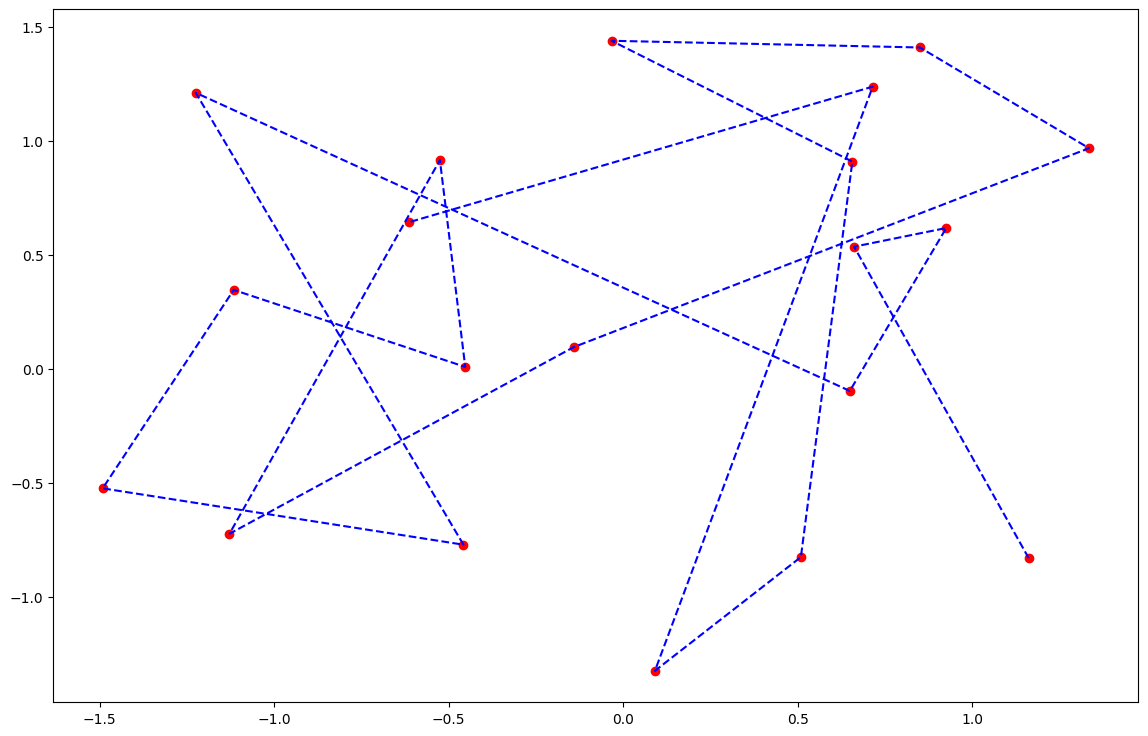

In [122]:
z = np.array([[np.random.uniform(-1.5, 1.5), np.random.uniform(-1.5, 1.5)] for _ in range(20)])

plt.figure(figsize=(14, 9))
plt.plot(z[:, 0], z[:, 1], '--', c='blue')
plt.scatter(z[:, 0], z[:, 1], c='red');



Обучим сеть и посмотрим на полученный результат.

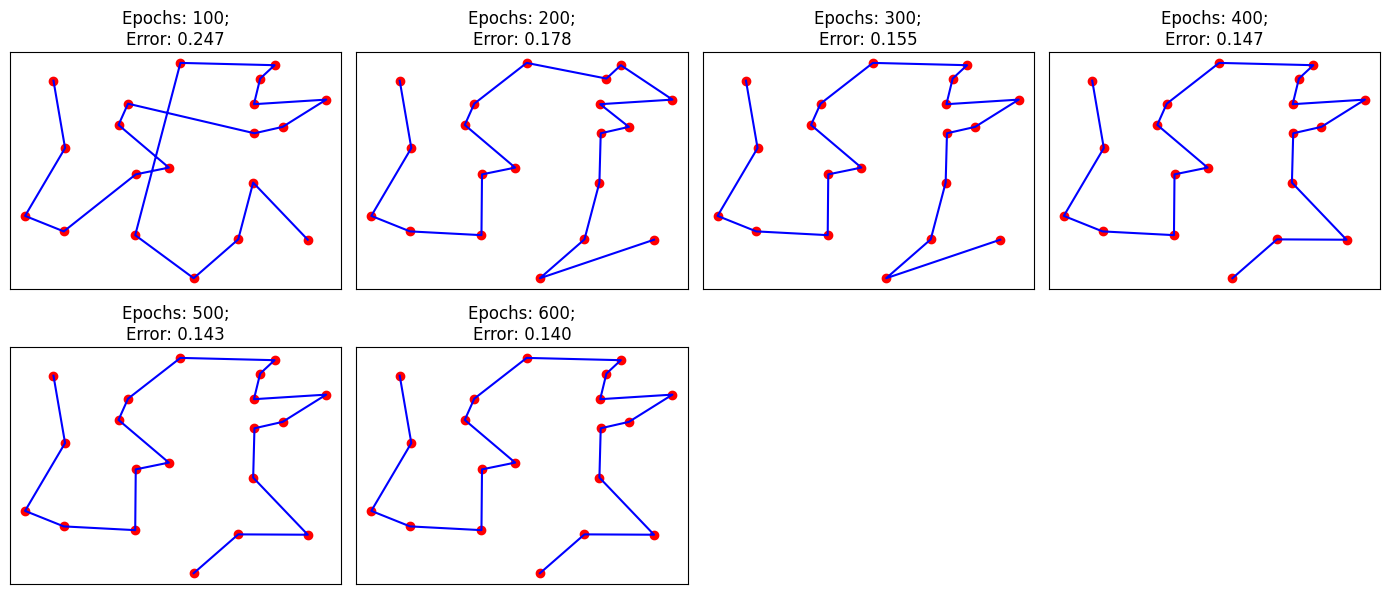

In [123]:
np.random.RandomState(10)
neurons = 80

som = MiniSom(1, neurons, z.shape[1], sigma=8, learning_rate=0.4,
              neighborhood_function='gaussian', random_seed=0)
som.random_weights_init(z)

plt.figure(figsize=(14, 9))
for i, iterations in enumerate(range(100, 601, 100)):
    som.train(z, iterations, verbose=False, random_order=False)
    plt.subplot(3, 4, i+1)
    plt.scatter(z[:, 0], z[:, 1], c='red')
    visit_order = np.argsort([som.winner(p)[1] for p in z])
    plt.plot(z[visit_order][:,0], z[visit_order][:,1], c='blue')
    plt.title("Epochs: {i};\nError: {e:.3f}".format(i=iterations,
                                                    e=som.quantization_error(z)))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()



## Задание 4
Использовать сеть векторного квантования, обучаемую с учителем, (LVQ-сеть) для клас-
сификации точек в случае, когда классы не являются линейно разделимыми.

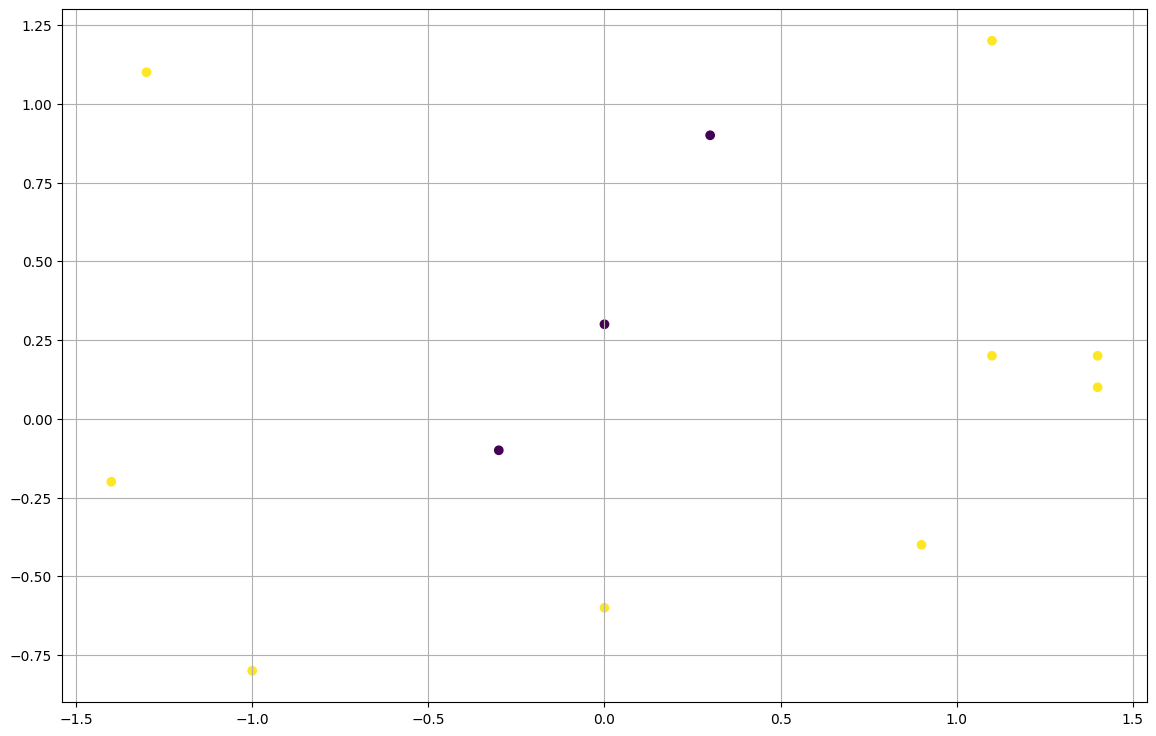

In [198]:
points = np.array([
    [1.4, 1.4, 0, -0.3, -1.3, -1.4, 0.9, 0.3, 1.1, -1, 1.1, 0],
    [0.2, 0.1, -0.6, -0.1, 1.1, -0.2, -0.4, 0.9, 1.2, -0.8, 0.2, 0.3]
])

target = np.array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0])
pointsT = points.T

plt.figure(figsize=(14, 9))
plt.scatter(pointsT[:, 0], pointsT[:, 1], c=target, cmap='viridis')
plt.grid(True)


Строим LVQ-сеть.

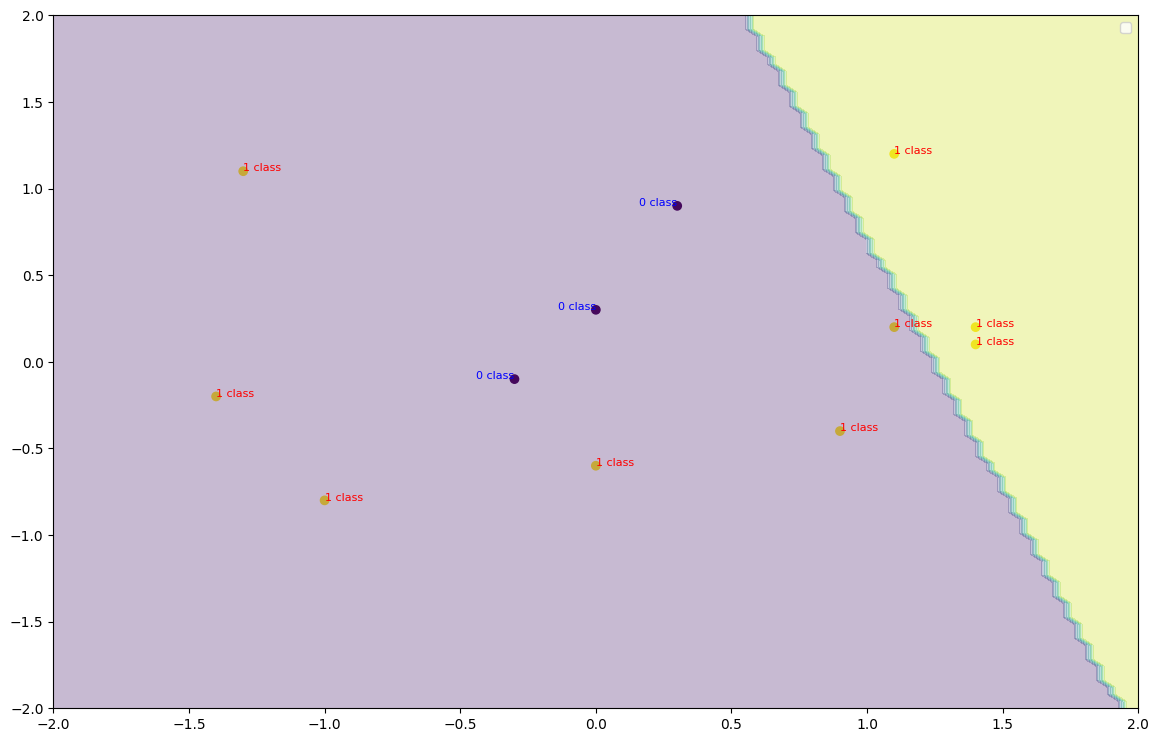

In [199]:
# Создаем LVQ-сеть с помощью MiniSom
som = MiniSom(2, 1, 2, sigma=0.5, learning_rate=0.5, random_seed=10)
som.random_weights_init(points.T)

# Функция для обучения LVQ-сети
def train_lvq(som, points, target, num_iterations):
    for i in range(num_iterations):
        rand_i = np.random.randint(0, len(points))
        som.update(points[:, rand_i], target[rand_i], i, num_iterations)

# Обучаем LVQ-сеть
train_lvq(som, points, target, 300)

# График с границами классов
plt.figure(figsize=(14, 9))
plt.scatter(points[0], points[1], c=target, cmap='viridis')

# Добавление подписей "0 class" и "1 class"
for i in range(12):
    if target[i] == 0:
        plt.text(points[0][i], points[1][i], '0 class', color='blue', fontsize=8, ha='right')
    else:
        plt.text(points[0][i], points[1][i], '1 class', color='red', fontsize=8, ha='left')

# Создаем сетку для построения контуров
x, y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

# Получаем победителей для точек на сетке
pred = np.array([som.winner([i, j]) for i, j in zip(x.flatten(), y.flatten())])

# Преобразуем результаты для построения контуров
pred_map = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        pred_map[i, j] = pred[i * 100 + j][0]

plt.contourf(x, y, pred_map, alpha=0.3, cmap='viridis')

plt.legend()
plt.show()


## Вывод
В ходе выполнения лабораторной работы я познакомилась с самоорганизующейся картой Кохонена, реализовал её для кластеризации точек на плоскости и кластеризации на гексогональной сетке. А также с помощью карты Кохонена решила задачу для нахождения одного из решений задачи коммивояжера.
Также в работе надо было использовать сеть обучаемую с учителем (LVQ-сеть) для классификации точек в случае не линейно разделимы классы.
На мой взгляд результаты в заданиях получились достаточно точными.
